In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [3]:
train

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131657,T0005908509,11.72,D,1.0,2.74229,A,A,3.28500,0,61.0,47,76,Male,3
131658,T0005908510,74.81,C,7.0,2.81059,C,A,0.44500,0,NaN,63,88,Male,2
131659,T0005908512,40.17,C,10.0,2.99565,B,A,3.33625,0,NaN,48,75,Female,2
131660,T0005908513,46.88,B,4.0,3.04744,A,B,4.15750,1,47.0,54,79,Male,2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  111452 non-null  object 
 3   Customer_Since_Months        125742 non-null  float64
 4   Life_Style_Index             111469 non-null  float64
 5   Confidence_Life_Style_Index  111469 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         60632 non-null   float64
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12  Gender                       131662 non-null  object 
 13 

In [5]:
train.isna().sum()/len(train) * 100

Trip_ID                         0.000000
Trip_Distance                   0.000000
Type_of_Cab                    15.349911
Customer_Since_Months           4.496362
Life_Style_Index               15.336999
Confidence_Life_Style_Index    15.336999
Destination_Type                0.000000
Customer_Rating                 0.000000
Cancellation_Last_1Month        0.000000
Var1                           53.948748
Var2                            0.000000
Var3                            0.000000
Gender                          0.000000
Surge_Pricing_Type              0.000000
dtype: float64

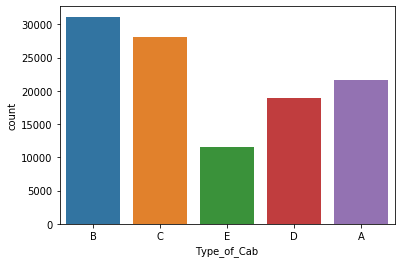

In [6]:
sns.countplot(x = 'Type_of_Cab',data = train)

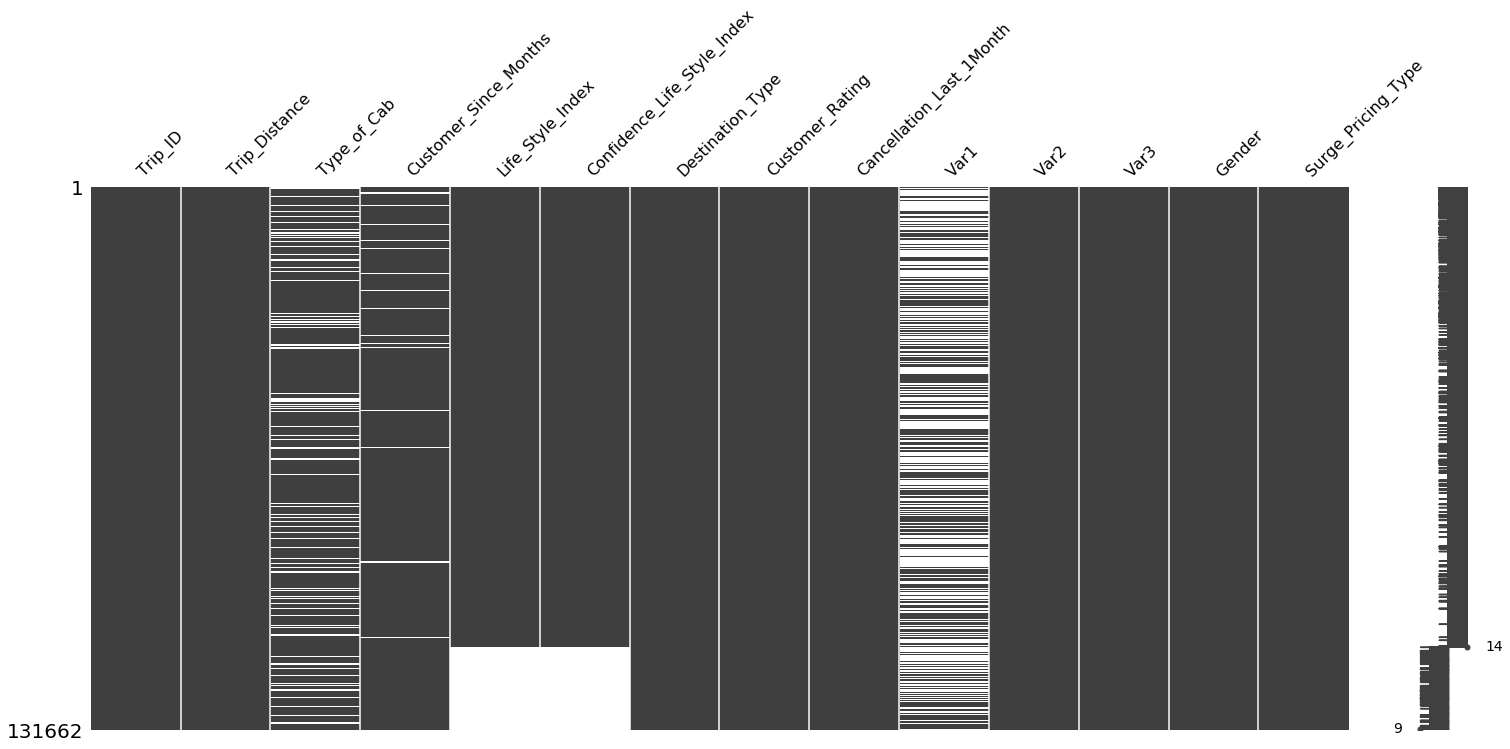

In [7]:
msno.matrix(train.sort_values(by = 'Life_Style_Index')) 
# Denotes that the columns life style index and the confidence are missing together

In [8]:
train['Gender'] = train['Gender'].replace('Female',0).replace('Male',1)
test['Gender'] = test['Gender'].replace('Female',0).replace('Male',1)
train['Gender'] = train['Gender'].astype('category')
test['Gender'] = test['Gender'].astype('category')

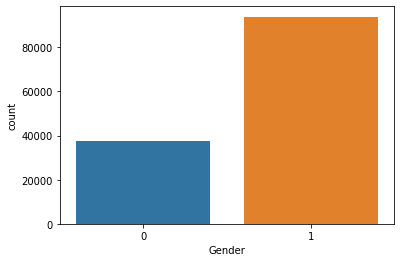

In [9]:
sns.countplot('Gender',data = train) 

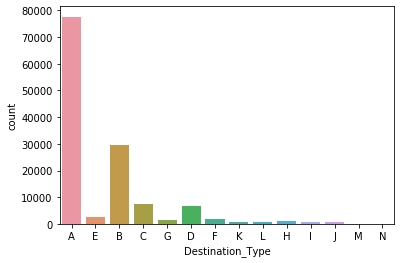

In [10]:
sns.countplot('Destination_Type',data = train) # Frequency encoding is required

In [11]:
train['Type_of_Cab'].replace(np.NaN,'Null',inplace = True)
test['Type_of_Cab'].replace(np.NaN,'Null',inplace = True)
train['Type_of_Cab'] = train['Type_of_Cab'].astype('category')
test['Type_of_Cab'] = test['Type_of_Cab'].astype('category')

In [12]:
train.groupby('Type_of_Cab')['Var1'].sum()

Type_of_Cab
A       525545.0
B       923771.0
C       871787.0
D       611114.0
E       364310.0
Null    596211.0
Name: Var1, dtype: float64

In [13]:
x = np.log(train.groupby('Destination_Type')['Trip_ID'].count()).to_dict()
train['Destination_Type'] = train['Destination_Type'].map(x)
test['Destination_Type'] = test['Destination_Type'].map(x)

In [15]:
le = LabelEncoder()
train['Type_of_Cab'] = le.fit_transform(train['Type_of_Cab'])
test['Type_of_Cab'] = le.transform(test['Type_of_Cab'])

In [16]:
train.drop('Var1',inplace = True,axis = 1)
test.drop('Var1',inplace = True,axis = 1)

In [17]:
#train['exp'] = np.exp(train['Life_Style_Index'])
train.groupby('Type_of_Cab')['Life_Style_Index'].max()

Type_of_Cab
0    4.85378
1    4.59115
2    4.07072
3    4.65904
4    4.87511
5    4.30083
Name: Life_Style_Index, dtype: float64

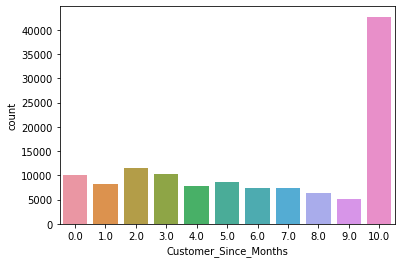

In [18]:
sns.countplot(x = 'Customer_Since_Months',data = train)
#train.info()

In [19]:
train['Customer_Since_Months'] = train['Customer_Since_Months'].fillna(6)
test['Customer_Since_Months'] = test['Customer_Since_Months'].fillna(6)

In [20]:
x,y = train['Life_Style_Index'].median(),train['Life_Style_Index'].mean()
train['Life_Style_Index'] = train['Life_Style_Index'].fillna(x)
test['Life_Style_Index'] = test['Life_Style_Index'].fillna(x)

In [21]:
train['Confidence_Life_Style_Index'] = train['Confidence_Life_Style_Index'].fillna('Null')
test['Confidence_Life_Style_Index'] = test['Confidence_Life_Style_Index'].fillna('Null')
train.groupby('Confidence_Life_Style_Index')['Trip_ID'].count()

Confidence_Life_Style_Index
A       35147
B       40355
C       35967
Null    20193
Name: Trip_ID, dtype: int64

In [22]:
a = LabelEncoder()
train['Confidence_Life_Style_Index'] = a.fit_transform(train['Confidence_Life_Style_Index'])
test['Confidence_Life_Style_Index'] = a.transform(test['Confidence_Life_Style_Index'])

In [23]:
X = train.iloc[:,1:12].values
y = train.iloc[:,-1].values
X,y

(array([[6.77, 1, 1.0, ..., 46, 60, 0],
        [29.47, 1, 10.0, ..., 56, 78, 1],
        [41.58, 5, 10.0, ..., 56, 77, 1],
        ...,
        [40.17, 2, 10.0, ..., 48, 75, 0],
        [46.88, 1, 4.0, ..., 54, 79, 1],
        [31.96, 0, 7.0, ..., 57, 85, 1]], dtype=object),
 array([2, 2, 2, ..., 2, 2, 1], dtype=int64))

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [24]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf.score(X_train,y_train)

1.0

In [25]:
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.6918402997544242

In [26]:
parameters = { 'max_features':np.arange(5,10),'n_estimators':[100],'min_samples_leaf': [10,50,100,200,500]}
random_grid = GridSearchCV(rf, parameters, cv = 5,n_jobs = -1)
random_grid.fit(X_train,y_train)
random_grid.best_score_,random_grid.best_params_

(0.6948884305143025,
 {'max_features': 7, 'min_samples_leaf': 50, 'n_estimators': 100})

In [27]:
y_pred = random_grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred)

0.6946504974809489

In [28]:
# Iteration 1 rf:
parameters = { 'max_depth':[4,6],'n_estimators':[100,200],'min_samples_leaf': [10,50,100,200]}
random_grid = GridSearchCV(rf, parameters, cv = 5,n_jobs = -1)
random_grid.fit(X_train,y_train)
print('Best score:',random_grid.best_score_)
print('Best Params:',random_grid.best_params_)

Best score: 0.6839838946567751
Best Params: {'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 200}


In [31]:
y_pred = random_grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred) #0.6861945872047394

0.6860426846249272

In [30]:
# Iteration 2
parameters = {'max_depth':[4,6],
              'n_estimators':[100,200],
              'min_samples_leaf': [10,50,100,200]}
random_grid = GridSearchCV(rf, parameters, cv = StratifiedKFold(n_splits = 5, shuffle = True),n_jobs = -1)
random_grid.fit(X_train,y_train)
print('Best score:',random_grid.best_score_)
print('Best Params:',random_grid.best_params_)

Best score: 0.6842117174455385
Best Params: {'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 200}


In [29]:
y_pred = random_grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred) #0.6861945872047394

0.6856376110787615

<BarContainer object of 11 artists>

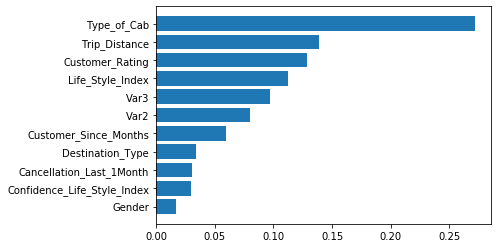

In [32]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,rf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [34]:
test_X = test.iloc[:,1:12].values
test_y = random_grid.best_estimator_.predict(test_X)

sub_rf = pd.DataFrame()
sub_rf['Trip_ID'] = submission['Trip_ID']
sub_rf['Surge_Pricing_Type'] = test_y
#sub_rf.to_csv('Random_Forest.csv',ignore_index = True)

In [35]:
clf = AdaBoostClassifier(random_state = 41)
clf.fit(X_train,y_train)

print('Accuracy on train:',clf.score(X_train,y_train))
print('Accuracy on test:',clf.score(X_test,y_test))

Accuracy on train: 0.6876837776548073
Accuracy on test: 0.6898655662168662


In [36]:
parameters = [{'learning_rate' : [0.2,0.4,0.6,0.75,1],
               'n_estimators' : [150,200,225,250]}]
grid_search = GridSearchCV(estimator = clf,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           cv = StratifiedKFold(n_splits = 5, shuffle = True) 
)
grid = grid_search.fit(X_train,y_train)
grid.best_params_, grid.best_score_,grid.best_estimator_

({'learning_rate': 0.75, 'n_estimators': 200},
 0.689658574154822,
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.75,
                    n_estimators=200, random_state=41))

In [37]:
y_pred = grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred)

0.692042836527507

In [38]:
test_X = test.iloc[:,1:12].values
test_y = grid.best_estimator_.predict(test_X)

sub_ada = pd.DataFrame()
sub_ada['Trip_ID'] = submission['Trip_ID']
sub_ada['Surge_Pricing_Type'] = test_y
#sub_ada.to_csv('Adaboost_grid1.csv',index = False)

<BarContainer object of 11 artists>

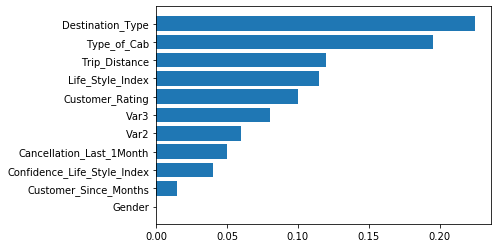

In [39]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,grid.best_estimator_.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [40]:
xgclf = XGBClassifier(random_state = 41)
xgclf.fit(X_train,y_train)

print('Accuracy on train:',clf.score(X_train,y_train))
print('Accuracy on test:',clf.score(X_test,y_test))

Accuracy on train: 0.6876837776548073
Accuracy on test: 0.6898655662168662


In [41]:
parameters = [{'learning_rate' : [0.2,0.3,0.4],
               'n_estimators' : [75,100],
               'max_depth' : [3,4,5,6],
               'min_child_weight':[1,3,4]}]
grid_search = GridSearchCV(estimator = xgclf,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           cv = StratifiedKFold(n_splits = 5, shuffle = True) 
)
grid = grid_search.fit(X_train,y_train)
grid.best_params_, grid.best_score_,grid.best_estimator_

({'learning_rate': 0.3,
  'max_depth': 4,
  'min_child_weight': 4,
  'n_estimators': 75},
 0.6985666911359157,
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints=None,
               learning_rate=0.3, max_delta_step=0, max_depth=4,
               min_child_weight=4, missing=nan, monotone_constraints=None,
               n_estimators=75, n_jobs=0, num_parallel_tree=1,
               objective='multi:softprob', random_state=41, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=None, subsample=1,
               tree_method=None, validate_parameters=False, verbosity=None))

In [42]:
y_pred = grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred)

0.6999164535811033

In [43]:
test_X = test.iloc[:,1:12].values
test_y = grid.best_estimator_.predict(test_X)

sub_ada = pd.DataFrame()
sub_ada['Trip_ID'] = submission['Trip_ID']
sub_ada['Surge_Pricing_Type'] = test_y
#sub_ada.to_csv('xg_grid2.csv',index = False)

<BarContainer object of 11 artists>

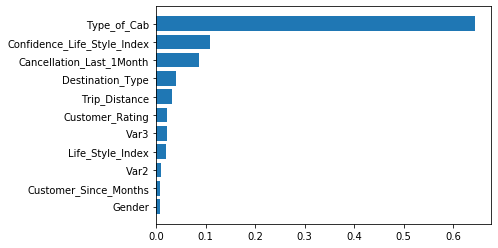

In [44]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,grid.best_estimator_.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [25]:
catclf = CatBoostClassifier(random_state = 41)
catclf.fit(X_train,y_train)

print('Accuracy on train:',catclf.score(X_train,y_train))
print('Accuracy on test:',catclf.score(X_test,y_test))

Learning rate set to 0.099659
0:	learn: 1.0368203	total: 252ms	remaining: 4m 12s
1:	learn: 0.9879711	total: 336ms	remaining: 2m 47s
2:	learn: 0.9486731	total: 392ms	remaining: 2m 10s
3:	learn: 0.9175601	total: 441ms	remaining: 1m 49s
4:	learn: 0.8913426	total: 492ms	remaining: 1m 37s
5:	learn: 0.8696875	total: 536ms	remaining: 1m 28s
6:	learn: 0.8516316	total: 579ms	remaining: 1m 22s
7:	learn: 0.8372625	total: 629ms	remaining: 1m 18s
8:	learn: 0.8250351	total: 683ms	remaining: 1m 15s
9:	learn: 0.8136888	total: 731ms	remaining: 1m 12s
10:	learn: 0.8051470	total: 786ms	remaining: 1m 10s
11:	learn: 0.7970601	total: 843ms	remaining: 1m 9s
12:	learn: 0.7897054	total: 905ms	remaining: 1m 8s
13:	learn: 0.7830320	total: 972ms	remaining: 1m 8s
14:	learn: 0.7777654	total: 1.03s	remaining: 1m 7s
15:	learn: 0.7726073	total: 1.07s	remaining: 1m 5s
16:	learn: 0.7683534	total: 1.12s	remaining: 1m 4s
17:	learn: 0.7644760	total: 1.17s	remaining: 1m 3s
18:	learn: 0.7609374	total: 1.22s	remaining: 1m 3s


162:	learn: 0.6962544	total: 7.73s	remaining: 39.7s
163:	learn: 0.6961696	total: 7.77s	remaining: 39.6s
164:	learn: 0.6960859	total: 7.82s	remaining: 39.5s
165:	learn: 0.6959821	total: 7.86s	remaining: 39.5s
166:	learn: 0.6959003	total: 7.91s	remaining: 39.4s
167:	learn: 0.6957686	total: 7.95s	remaining: 39.4s
168:	learn: 0.6956206	total: 8s	remaining: 39.3s
169:	learn: 0.6955409	total: 8.04s	remaining: 39.2s
170:	learn: 0.6954552	total: 8.08s	remaining: 39.2s
171:	learn: 0.6953312	total: 8.13s	remaining: 39.1s
172:	learn: 0.6952322	total: 8.16s	remaining: 39s
173:	learn: 0.6951127	total: 8.2s	remaining: 38.9s
174:	learn: 0.6950268	total: 8.24s	remaining: 38.9s
175:	learn: 0.6949713	total: 8.29s	remaining: 38.8s
176:	learn: 0.6949052	total: 8.34s	remaining: 38.8s
177:	learn: 0.6948112	total: 8.38s	remaining: 38.7s
178:	learn: 0.6947063	total: 8.42s	remaining: 38.6s
179:	learn: 0.6945869	total: 8.47s	remaining: 38.6s
180:	learn: 0.6944589	total: 8.51s	remaining: 38.5s
181:	learn: 0.6943

322:	learn: 0.6829826	total: 15.4s	remaining: 32.2s
323:	learn: 0.6829555	total: 15.4s	remaining: 32.2s
324:	learn: 0.6829105	total: 15.5s	remaining: 32.1s
325:	learn: 0.6828685	total: 15.5s	remaining: 32s
326:	learn: 0.6827901	total: 15.5s	remaining: 32s
327:	learn: 0.6826846	total: 15.6s	remaining: 31.9s
328:	learn: 0.6826043	total: 15.6s	remaining: 31.9s
329:	learn: 0.6825168	total: 15.7s	remaining: 31.8s
330:	learn: 0.6824797	total: 15.7s	remaining: 31.8s
331:	learn: 0.6824451	total: 15.8s	remaining: 31.7s
332:	learn: 0.6824106	total: 15.8s	remaining: 31.6s
333:	learn: 0.6823286	total: 15.8s	remaining: 31.6s
334:	learn: 0.6822415	total: 15.9s	remaining: 31.5s
335:	learn: 0.6821843	total: 15.9s	remaining: 31.5s
336:	learn: 0.6821081	total: 16s	remaining: 31.4s
337:	learn: 0.6820383	total: 16s	remaining: 31.4s
338:	learn: 0.6819778	total: 16.1s	remaining: 31.3s
339:	learn: 0.6818994	total: 16.1s	remaining: 31.3s
340:	learn: 0.6818253	total: 16.2s	remaining: 31.3s
341:	learn: 0.681731

481:	learn: 0.6727466	total: 23.5s	remaining: 25.3s
482:	learn: 0.6726466	total: 23.6s	remaining: 25.3s
483:	learn: 0.6725518	total: 23.7s	remaining: 25.2s
484:	learn: 0.6724916	total: 23.7s	remaining: 25.2s
485:	learn: 0.6724285	total: 23.7s	remaining: 25.1s
486:	learn: 0.6724159	total: 23.8s	remaining: 25.1s
487:	learn: 0.6723545	total: 23.8s	remaining: 25s
488:	learn: 0.6723072	total: 23.9s	remaining: 25s
489:	learn: 0.6722335	total: 23.9s	remaining: 24.9s
490:	learn: 0.6721497	total: 24s	remaining: 24.9s
491:	learn: 0.6721059	total: 24s	remaining: 24.8s
492:	learn: 0.6720388	total: 24.1s	remaining: 24.8s
493:	learn: 0.6719941	total: 24.1s	remaining: 24.7s
494:	learn: 0.6719570	total: 24.2s	remaining: 24.7s
495:	learn: 0.6718752	total: 24.2s	remaining: 24.6s
496:	learn: 0.6717951	total: 24.3s	remaining: 24.6s
497:	learn: 0.6717493	total: 24.3s	remaining: 24.5s
498:	learn: 0.6716862	total: 24.4s	remaining: 24.5s
499:	learn: 0.6716367	total: 24.4s	remaining: 24.4s
500:	learn: 0.671588

640:	learn: 0.6629997	total: 31.4s	remaining: 17.6s
641:	learn: 0.6629288	total: 31.4s	remaining: 17.5s
642:	learn: 0.6628667	total: 31.5s	remaining: 17.5s
643:	learn: 0.6628099	total: 31.5s	remaining: 17.4s
644:	learn: 0.6627528	total: 31.6s	remaining: 17.4s
645:	learn: 0.6626736	total: 31.6s	remaining: 17.3s
646:	learn: 0.6626254	total: 31.7s	remaining: 17.3s
647:	learn: 0.6625650	total: 31.7s	remaining: 17.2s
648:	learn: 0.6625090	total: 31.8s	remaining: 17.2s
649:	learn: 0.6624480	total: 31.8s	remaining: 17.1s
650:	learn: 0.6624031	total: 31.9s	remaining: 17.1s
651:	learn: 0.6623387	total: 31.9s	remaining: 17s
652:	learn: 0.6623032	total: 31.9s	remaining: 17s
653:	learn: 0.6622443	total: 32s	remaining: 16.9s
654:	learn: 0.6621825	total: 32s	remaining: 16.9s
655:	learn: 0.6620894	total: 32.1s	remaining: 16.8s
656:	learn: 0.6620121	total: 32.1s	remaining: 16.8s
657:	learn: 0.6619490	total: 32.2s	remaining: 16.7s
658:	learn: 0.6618748	total: 32.2s	remaining: 16.7s
659:	learn: 0.661804

799:	learn: 0.6543494	total: 38.5s	remaining: 9.62s
800:	learn: 0.6542908	total: 38.5s	remaining: 9.57s
801:	learn: 0.6541920	total: 38.6s	remaining: 9.52s
802:	learn: 0.6541530	total: 38.6s	remaining: 9.47s
803:	learn: 0.6540855	total: 38.7s	remaining: 9.43s
804:	learn: 0.6540281	total: 38.7s	remaining: 9.38s
805:	learn: 0.6539639	total: 38.8s	remaining: 9.33s
806:	learn: 0.6539003	total: 38.8s	remaining: 9.28s
807:	learn: 0.6538436	total: 38.8s	remaining: 9.23s
808:	learn: 0.6537558	total: 38.9s	remaining: 9.18s
809:	learn: 0.6536845	total: 38.9s	remaining: 9.13s
810:	learn: 0.6536324	total: 39s	remaining: 9.09s
811:	learn: 0.6535638	total: 39s	remaining: 9.04s
812:	learn: 0.6535192	total: 39.1s	remaining: 8.99s
813:	learn: 0.6534427	total: 39.1s	remaining: 8.94s
814:	learn: 0.6533959	total: 39.2s	remaining: 8.89s
815:	learn: 0.6533562	total: 39.2s	remaining: 8.84s
816:	learn: 0.6532970	total: 39.2s	remaining: 8.79s
817:	learn: 0.6532579	total: 39.3s	remaining: 8.74s
818:	learn: 0.65

959:	learn: 0.6458683	total: 46.1s	remaining: 1.92s
960:	learn: 0.6458086	total: 46.1s	remaining: 1.87s
961:	learn: 0.6457618	total: 46.2s	remaining: 1.82s
962:	learn: 0.6457194	total: 46.2s	remaining: 1.77s
963:	learn: 0.6456738	total: 46.3s	remaining: 1.73s
964:	learn: 0.6456255	total: 46.3s	remaining: 1.68s
965:	learn: 0.6455806	total: 46.4s	remaining: 1.63s
966:	learn: 0.6455408	total: 46.4s	remaining: 1.58s
967:	learn: 0.6454997	total: 46.4s	remaining: 1.53s
968:	learn: 0.6454602	total: 46.5s	remaining: 1.49s
969:	learn: 0.6453889	total: 46.5s	remaining: 1.44s
970:	learn: 0.6453418	total: 46.6s	remaining: 1.39s
971:	learn: 0.6452983	total: 46.6s	remaining: 1.34s
972:	learn: 0.6452553	total: 46.7s	remaining: 1.29s
973:	learn: 0.6452000	total: 46.7s	remaining: 1.25s
974:	learn: 0.6451540	total: 46.8s	remaining: 1.2s
975:	learn: 0.6451211	total: 46.8s	remaining: 1.15s
976:	learn: 0.6450896	total: 46.9s	remaining: 1.1s
977:	learn: 0.6450367	total: 46.9s	remaining: 1.05s
978:	learn: 0.

In [33]:
parameters = [{'learning_rate' : [0.2,0.3,0.4],
               'depth' : [6,8,10],
               'iterations':[1500]}]
grid_search = GridSearchCV(estimator = catclf,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           cv = StratifiedKFold(n_splits = 5, shuffle = True),
                           verbose = 10
)
grid = grid_search.fit(X_train,y_train)
grid.best_params_, grid.best_score_,grid.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed: 44.3min remaining: 12.6min
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed: 55.2min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 57.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 57.4min finished


0:	learn: 0.9814152	total: 51ms	remaining: 1m 16s
1:	learn: 0.9104392	total: 95.1ms	remaining: 1m 11s
2:	learn: 0.8651000	total: 127ms	remaining: 1m 3s
3:	learn: 0.8336377	total: 165ms	remaining: 1m 1s
4:	learn: 0.8100817	total: 206ms	remaining: 1m 1s
5:	learn: 0.7922654	total: 245ms	remaining: 1m 1s
6:	learn: 0.7793866	total: 288ms	remaining: 1m 1s
7:	learn: 0.7696985	total: 326ms	remaining: 1m
8:	learn: 0.7610505	total: 368ms	remaining: 1m
9:	learn: 0.7552736	total: 399ms	remaining: 59.5s
10:	learn: 0.7499919	total: 435ms	remaining: 58.8s
11:	learn: 0.7453885	total: 471ms	remaining: 58.3s
12:	learn: 0.7416443	total: 506ms	remaining: 57.9s
13:	learn: 0.7381047	total: 544ms	remaining: 57.7s
14:	learn: 0.7352006	total: 589ms	remaining: 58.3s
15:	learn: 0.7330340	total: 620ms	remaining: 57.5s
16:	learn: 0.7303673	total: 660ms	remaining: 57.6s
17:	learn: 0.7284184	total: 696ms	remaining: 57.3s
18:	learn: 0.7264658	total: 732ms	remaining: 57.1s
19:	learn: 0.7245592	total: 761ms	remaining: 

162:	learn: 0.6835305	total: 5.68s	remaining: 46.6s
163:	learn: 0.6834179	total: 5.72s	remaining: 46.6s
164:	learn: 0.6832625	total: 5.76s	remaining: 46.6s
165:	learn: 0.6830800	total: 5.8s	remaining: 46.6s
166:	learn: 0.6829439	total: 5.83s	remaining: 46.6s
167:	learn: 0.6828072	total: 5.88s	remaining: 46.6s
168:	learn: 0.6826004	total: 5.93s	remaining: 46.7s
169:	learn: 0.6824112	total: 5.97s	remaining: 46.7s
170:	learn: 0.6822907	total: 6.01s	remaining: 46.7s
171:	learn: 0.6821428	total: 6.05s	remaining: 46.7s
172:	learn: 0.6820106	total: 6.09s	remaining: 46.7s
173:	learn: 0.6817937	total: 6.13s	remaining: 46.7s
174:	learn: 0.6816369	total: 6.17s	remaining: 46.7s
175:	learn: 0.6814860	total: 6.21s	remaining: 46.7s
176:	learn: 0.6813041	total: 6.24s	remaining: 46.7s
177:	learn: 0.6812140	total: 6.28s	remaining: 46.6s
178:	learn: 0.6810418	total: 6.32s	remaining: 46.6s
179:	learn: 0.6808638	total: 6.36s	remaining: 46.6s
180:	learn: 0.6806720	total: 6.39s	remaining: 46.6s
181:	learn: 0

323:	learn: 0.6634147	total: 11.5s	remaining: 41.9s
324:	learn: 0.6632486	total: 11.6s	remaining: 41.8s
325:	learn: 0.6631396	total: 11.6s	remaining: 41.8s
326:	learn: 0.6630748	total: 11.6s	remaining: 41.7s
327:	learn: 0.6629494	total: 11.7s	remaining: 41.7s
328:	learn: 0.6628495	total: 11.7s	remaining: 41.7s
329:	learn: 0.6627081	total: 11.7s	remaining: 41.6s
330:	learn: 0.6625933	total: 11.8s	remaining: 41.6s
331:	learn: 0.6624564	total: 11.8s	remaining: 41.6s
332:	learn: 0.6623410	total: 11.9s	remaining: 41.5s
333:	learn: 0.6622477	total: 11.9s	remaining: 41.5s
334:	learn: 0.6621782	total: 11.9s	remaining: 41.4s
335:	learn: 0.6620863	total: 12s	remaining: 41.4s
336:	learn: 0.6619710	total: 12s	remaining: 41.4s
337:	learn: 0.6619030	total: 12s	remaining: 41.3s
338:	learn: 0.6617682	total: 12.1s	remaining: 41.3s
339:	learn: 0.6616746	total: 12.1s	remaining: 41.3s
340:	learn: 0.6615567	total: 12.1s	remaining: 41.2s
341:	learn: 0.6614133	total: 12.2s	remaining: 41.2s
342:	learn: 0.6613

483:	learn: 0.6469773	total: 16.7s	remaining: 35.1s
484:	learn: 0.6468716	total: 16.8s	remaining: 35.1s
485:	learn: 0.6467720	total: 16.8s	remaining: 35s
486:	learn: 0.6467090	total: 16.8s	remaining: 35s
487:	learn: 0.6466191	total: 16.9s	remaining: 35s
488:	learn: 0.6465409	total: 16.9s	remaining: 34.9s
489:	learn: 0.6464332	total: 16.9s	remaining: 34.9s
490:	learn: 0.6462952	total: 17s	remaining: 34.8s
491:	learn: 0.6462313	total: 17s	remaining: 34.8s
492:	learn: 0.6460781	total: 17s	remaining: 34.8s
493:	learn: 0.6460293	total: 17.1s	remaining: 34.7s
494:	learn: 0.6458969	total: 17.1s	remaining: 34.7s
495:	learn: 0.6457951	total: 17.1s	remaining: 34.7s
496:	learn: 0.6457072	total: 17.2s	remaining: 34.6s
497:	learn: 0.6455919	total: 17.2s	remaining: 34.6s
498:	learn: 0.6455223	total: 17.2s	remaining: 34.5s
499:	learn: 0.6454360	total: 17.2s	remaining: 34.5s
500:	learn: 0.6453585	total: 17.3s	remaining: 34.4s
501:	learn: 0.6452256	total: 17.3s	remaining: 34.4s
502:	learn: 0.6451398	to

645:	learn: 0.6308908	total: 21.8s	remaining: 28.8s
646:	learn: 0.6308133	total: 21.8s	remaining: 28.7s
647:	learn: 0.6307260	total: 21.8s	remaining: 28.7s
648:	learn: 0.6306149	total: 21.9s	remaining: 28.7s
649:	learn: 0.6305058	total: 21.9s	remaining: 28.6s
650:	learn: 0.6303948	total: 21.9s	remaining: 28.6s
651:	learn: 0.6302883	total: 21.9s	remaining: 28.5s
652:	learn: 0.6301818	total: 22s	remaining: 28.5s
653:	learn: 0.6300593	total: 22s	remaining: 28.5s
654:	learn: 0.6299666	total: 22s	remaining: 28.4s
655:	learn: 0.6297956	total: 22.1s	remaining: 28.4s
656:	learn: 0.6296725	total: 22.1s	remaining: 28.4s
657:	learn: 0.6295379	total: 22.2s	remaining: 28.3s
658:	learn: 0.6294253	total: 22.2s	remaining: 28.3s
659:	learn: 0.6293430	total: 22.2s	remaining: 28.3s
660:	learn: 0.6292351	total: 22.3s	remaining: 28.3s
661:	learn: 0.6291402	total: 22.3s	remaining: 28.2s
662:	learn: 0.6290368	total: 22.3s	remaining: 28.2s
663:	learn: 0.6289331	total: 22.4s	remaining: 28.2s
664:	learn: 0.6288

810:	learn: 0.6159328	total: 27s	remaining: 22.9s
811:	learn: 0.6158390	total: 27s	remaining: 22.9s
812:	learn: 0.6157391	total: 27s	remaining: 22.9s
813:	learn: 0.6156320	total: 27.1s	remaining: 22.8s
814:	learn: 0.6155056	total: 27.1s	remaining: 22.8s
815:	learn: 0.6154356	total: 27.1s	remaining: 22.7s
816:	learn: 0.6153479	total: 27.1s	remaining: 22.7s
817:	learn: 0.6152936	total: 27.2s	remaining: 22.7s
818:	learn: 0.6152301	total: 27.2s	remaining: 22.6s
819:	learn: 0.6151619	total: 27.2s	remaining: 22.6s
820:	learn: 0.6150876	total: 27.3s	remaining: 22.5s
821:	learn: 0.6150095	total: 27.3s	remaining: 22.5s
822:	learn: 0.6149175	total: 27.3s	remaining: 22.5s
823:	learn: 0.6148732	total: 27.3s	remaining: 22.4s
824:	learn: 0.6147617	total: 27.4s	remaining: 22.4s
825:	learn: 0.6146888	total: 27.4s	remaining: 22.3s
826:	learn: 0.6146015	total: 27.4s	remaining: 22.3s
827:	learn: 0.6145077	total: 27.4s	remaining: 22.3s
828:	learn: 0.6144323	total: 27.5s	remaining: 22.2s
829:	learn: 0.6143

974:	learn: 0.6022103	total: 31.6s	remaining: 17s
975:	learn: 0.6021492	total: 31.6s	remaining: 17s
976:	learn: 0.6020444	total: 31.7s	remaining: 16.9s
977:	learn: 0.6019252	total: 31.7s	remaining: 16.9s
978:	learn: 0.6018533	total: 31.7s	remaining: 16.9s
979:	learn: 0.6017699	total: 31.8s	remaining: 16.9s
980:	learn: 0.6016998	total: 31.8s	remaining: 16.8s
981:	learn: 0.6016324	total: 31.9s	remaining: 16.8s
982:	learn: 0.6015544	total: 31.9s	remaining: 16.8s
983:	learn: 0.6014912	total: 32s	remaining: 16.8s
984:	learn: 0.6013918	total: 32s	remaining: 16.7s
985:	learn: 0.6013244	total: 32s	remaining: 16.7s
986:	learn: 0.6012487	total: 32.1s	remaining: 16.7s
987:	learn: 0.6011697	total: 32.1s	remaining: 16.6s
988:	learn: 0.6011120	total: 32.1s	remaining: 16.6s
989:	learn: 0.6010289	total: 32.2s	remaining: 16.6s
990:	learn: 0.6009675	total: 32.2s	remaining: 16.5s
991:	learn: 0.6008771	total: 32.2s	remaining: 16.5s
992:	learn: 0.6008061	total: 32.3s	remaining: 16.5s
993:	learn: 0.6007461	

1136:	learn: 0.5888174	total: 36.8s	remaining: 11.8s
1137:	learn: 0.5887656	total: 36.9s	remaining: 11.7s
1138:	learn: 0.5886947	total: 36.9s	remaining: 11.7s
1139:	learn: 0.5886074	total: 36.9s	remaining: 11.7s
1140:	learn: 0.5885263	total: 37s	remaining: 11.6s
1141:	learn: 0.5884533	total: 37s	remaining: 11.6s
1142:	learn: 0.5883537	total: 37s	remaining: 11.6s
1143:	learn: 0.5882886	total: 37s	remaining: 11.5s
1144:	learn: 0.5882411	total: 37.1s	remaining: 11.5s
1145:	learn: 0.5881677	total: 37.1s	remaining: 11.5s
1146:	learn: 0.5881033	total: 37.1s	remaining: 11.4s
1147:	learn: 0.5879983	total: 37.1s	remaining: 11.4s
1148:	learn: 0.5879522	total: 37.2s	remaining: 11.4s
1149:	learn: 0.5878777	total: 37.2s	remaining: 11.3s
1150:	learn: 0.5878009	total: 37.2s	remaining: 11.3s
1151:	learn: 0.5877470	total: 37.3s	remaining: 11.3s
1152:	learn: 0.5876714	total: 37.3s	remaining: 11.2s
1153:	learn: 0.5875852	total: 37.3s	remaining: 11.2s
1154:	learn: 0.5875353	total: 37.3s	remaining: 11.2s
1

1292:	learn: 0.5775827	total: 42.1s	remaining: 6.74s
1293:	learn: 0.5775093	total: 42.1s	remaining: 6.71s
1294:	learn: 0.5774375	total: 42.2s	remaining: 6.67s
1295:	learn: 0.5774204	total: 42.2s	remaining: 6.64s
1296:	learn: 0.5773707	total: 42.2s	remaining: 6.61s
1297:	learn: 0.5772987	total: 42.2s	remaining: 6.57s
1298:	learn: 0.5772373	total: 42.3s	remaining: 6.54s
1299:	learn: 0.5771620	total: 42.3s	remaining: 6.51s
1300:	learn: 0.5770982	total: 42.3s	remaining: 6.47s
1301:	learn: 0.5770475	total: 42.4s	remaining: 6.44s
1302:	learn: 0.5769420	total: 42.4s	remaining: 6.41s
1303:	learn: 0.5768703	total: 42.4s	remaining: 6.37s
1304:	learn: 0.5768296	total: 42.4s	remaining: 6.34s
1305:	learn: 0.5767219	total: 42.5s	remaining: 6.31s
1306:	learn: 0.5766466	total: 42.5s	remaining: 6.27s
1307:	learn: 0.5765750	total: 42.5s	remaining: 6.24s
1308:	learn: 0.5764955	total: 42.6s	remaining: 6.21s
1309:	learn: 0.5764152	total: 42.6s	remaining: 6.18s
1310:	learn: 0.5763476	total: 42.6s	remaining:

1449:	learn: 0.5664696	total: 46.8s	remaining: 1.61s
1450:	learn: 0.5664057	total: 46.8s	remaining: 1.58s
1451:	learn: 0.5663566	total: 46.9s	remaining: 1.55s
1452:	learn: 0.5663177	total: 46.9s	remaining: 1.52s
1453:	learn: 0.5662474	total: 46.9s	remaining: 1.48s
1454:	learn: 0.5661793	total: 47s	remaining: 1.45s
1455:	learn: 0.5661196	total: 47s	remaining: 1.42s
1456:	learn: 0.5660599	total: 47s	remaining: 1.39s
1457:	learn: 0.5660099	total: 47.1s	remaining: 1.35s
1458:	learn: 0.5659412	total: 47.1s	remaining: 1.32s
1459:	learn: 0.5658616	total: 47.1s	remaining: 1.29s
1460:	learn: 0.5657533	total: 47.2s	remaining: 1.26s
1461:	learn: 0.5656741	total: 47.2s	remaining: 1.23s
1462:	learn: 0.5656137	total: 47.2s	remaining: 1.19s
1463:	learn: 0.5655511	total: 47.3s	remaining: 1.16s
1464:	learn: 0.5654886	total: 47.3s	remaining: 1.13s
1465:	learn: 0.5654257	total: 47.3s	remaining: 1.1s
1466:	learn: 0.5653411	total: 47.4s	remaining: 1.06s
1467:	learn: 0.5652454	total: 47.4s	remaining: 1.03s


({'depth': 6, 'iterations': 1500, 'learning_rate': 0.2},
 0.6895391735440514,
 <catboost.core.CatBoostClassifier at 0x2c18f066988>)

In [34]:
print('Accuracy on train:',grid.best_estimator_.score(X_train,y_train))
print('Accuracy on test:',grid.best_estimator_.score(X_test,y_test))

Accuracy on train: 0.7724140924232067
Accuracy on test: 0.6942960581280538


In [37]:
test

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var2,Var3,Gender
0,T0005689459,9.44,0,10.0,2.57438,0,10.294008,3.68000,2,46,63,1
1,T0005689462,32.15,1,10.0,2.85143,0,11.259284,1.59375,0,49,80,0
2,T0005689463,10.38,2,4.0,2.70530,0,8.793005,4.50500,0,47,74,1
3,T0005689466,14.94,5,6.0,2.48159,2,7.907284,4.53000,0,43,54,1
4,T0005689468,32.03,1,7.0,2.81598,0,6.522093,4.60125,3,44,56,1
...,...,...,...,...,...,...,...,...,...,...,...,...
87390,T0005908503,29.43,2,3.0,2.40720,2,11.259284,0.99750,0,48,72,0
87391,T0005908504,14.83,2,10.0,2.57009,0,8.793005,4.74375,0,42,60,0
87392,T0005908505,37.86,0,6.0,3.08227,2,11.259284,1.63500,0,57,77,1
87393,T0005908511,10.63,2,1.0,2.79805,3,6.543912,2.59875,1,51,77,1


In [38]:
test_X = test.iloc[:,1:12].values
test_y = grid.best_estimator_.predict(test_X)

sub_ada = pd.DataFrame()
sub_ada['Trip_ID'] = submission['Trip_ID']
sub_ada['Surge_Pricing_Type'] = test_y
sub_ada.to_csv('cat_grid_1.csv',index = False)

<BarContainer object of 11 artists>

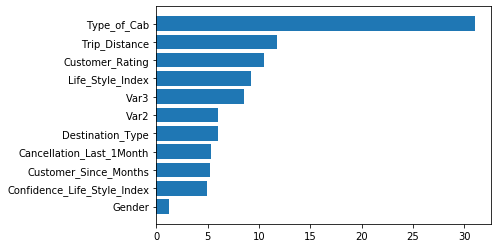

In [39]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,grid.best_estimator_.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [48]:
lgbclf = LGBMClassifier(random_state = 41)
lgbclf.fit(X_train,y_train)

print('Accuracy on train:',lgbclf.score(X_train,y_train))
print('Accuracy on test:',lgbclf.score(X_test,y_test))

Accuracy on train: 0.71132667122381
Accuracy on test: 0.6982961593964404


In [49]:
test_X = test.iloc[:,1:12].values
test_y = lgbclf.predict(test_X)

sub_ada = pd.DataFrame()
sub_ada['Trip_ID'] = submission['Trip_ID']
sub_ada['Surge_Pricing_Type'] = test_y
#sub_ada.to_csv('LightGBM_default.csv',index = False)

In [26]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,lgbclf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

NameError: name 'lgbclf' is not defined